<a href="https://colab.research.google.com/github/kamangirkhan/Data/blob/main/Project3_201DEC15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

This Dataset containes the details of the AI, ML, Data Science Salary (2020- 2025). Salary data is in USD and recalculated at its average fx rate during the year for salaries entered in other currencies.

The data is processed and updated on a weekly basis so the rankings may change over time during the year.
Introduction

This project analyzes a large, structured salary dataset containing compensation and employment information for professionals working in data-related roles across multiple countries. The dataset includes over 44,000 observations and records key attributes such as work year, experience level, employment type, job title, remote work ratio, company size, and geographic location of both the employee and employer. Salary information is reported in the original currency and standardized to U.S. dollars to enable consistent cross-regional comparisons.

The primary objective of this analysis is to examine the factors associated with variation in employee compensation and to evaluate the effectiveness of a Decision Tree Regression model in predicting salary outcomes. Prior to modeling, exploratory data analysis (EDA) is conducted to assess variable distributions, identify structural patterns, and gain insight into relationships between categorical and numerical features. The target variable for the predictive model is salary_in_usd, which represents total compensation normalized to a common currency.

This project is guided by the following research questions:

Which employment and job-related characteristics are most strongly associated with salary differences?

To what extent can a decision tree model explain and predict variation in salaries?

Which features emerge as the most influential predictors within the decision tree structure?

By integrating data preparation, visualization, predictive modeling, and interpretation, this project demonstrates a complete applied data analysis workflow consistent with the objectives and evaluation criteria of the DATA201 course.

**Attribute Information**

work_year
The year in which the salary was paid or recorded.

experience_level
The employee’s experience level, categorized as entry-level, mid-level, senior-level, or executive-level.

employment_type
The type of employment contract, such as full-time, part-time, contract, or freelance.

job_title
The employee’s job title or role within the organization.

salary
The employee’s salary amount in the original local currency.

salary_currency
The currency in which the salary was originally paid.

salary_in_usd
The employee’s salary converted to U.S. dollars, used as the primary target variable for modeling and comparison.

employee_residence
The country where the employee resides.

remote_ratio
The percentage of work performed remotely (0 = no remote work, 50 = hybrid, 100 = fully remote).

company_location
The country where the employer or company is located.

company_size
The size of the company, typically categorized as small, medium, or large.

In [ ]:
# DATA201 Decision Tree Project-3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn import tree


# 1) Load Data
df = pd.read_csv("salaries.csv")
print("Raw shape:", df.shape)
display(df.head())

# 2) Prepare & Wrangle Data
df.columns = df.columns.str.strip().str.replace(" ", "_")

df = df.drop_duplicates()


df = df.dropna()

print("After drop_duplicates + dropna shape:", df.shape)
display(df.describe(include="all").T.head(20))


Raw shape: (88584, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Customer Success Manager,57000,EUR,60000,NL,50,NL,L
1,2025,SE,FT,Engineer,165000,USD,165000,US,0,US,M
2,2025,SE,FT,Engineer,109000,USD,109000,US,0,US,M
3,2025,SE,FT,Applied Scientist,294000,USD,294000,US,0,US,M
4,2025,SE,FT,Applied Scientist,137600,USD,137600,US,0,US,M


After drop_duplicates + dropna shape: (44244, 11)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
work_year,44244.0,NaN,NaN,NaN,2024.065952,0.71382,2020.0,2024.0,2024.0,2024.0,2025.0
experience_level,44244,4,SE,23474,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_type,44244,4,FT,43821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_title,44244,312,Data Scientist,5207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,44244.0,NaN,NaN,NaN,159957.913683,267322.902756,14000.0,96200.0,140000.0,192000.0,30400000.0
salary_currency,44244,26,USD,40777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_in_usd,44244.0,NaN,NaN,NaN,151313.435788,77343.097878,15000.0,96200.0,139200.0,190315.0,800000.0
employee_residence,44244,96,US,37388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remote_ratio,44244.0,NaN,NaN,NaN,24.941235,43.075374,0.0,0.0,0.0,50.0,100.0
company_location,44244,90,US,37445,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

# 3) Choose Target Column (Salary/Pay/etc.)
candidate_targets = [
    "Salary", "SALARY", "salary",
    "Pay", "PAY", "pay",
    "TotalPay", "TOTALPAY", "totalpay",
    "Total_Pay", "TOTAL_PAY",
    "BasePay", "BASEPAY", "basepay",
    "Compensation", "COMPENSATION", "compensation"
]

target_col = None
for c in candidate_targets:
    if c in df.columns:
        target_col = c
        break

if target_col is None:

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found. Your dataset must contain a numeric salary/pay column.")
    target_col = df[numeric_cols].var().sort_values(ascending=False).index[0]
    print("WARNING: No standard salary column name found.")
    print("Auto-selected target column:", target_col)

print("Target column:", target_col)


df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
df = df.dropna(subset=[target_col])

df = df[df[target_col] >= 0]

print("Final shape after target cleanup:", df.shape)


Target column: salary
Final shape after target cleanup: (44244, 11)



--- Introduction (paste into your notebook/report) ---

This project uses salaries.csv, which contains salary/pay information along with
employee or job-related attributes (such as title, department, employment type, etc.).
The dataset contains 44244 rows and 11 columns after cleaning.

Questions:
1) Which variables appear to be strongest drivers of salary/pay?
2) Can a decision tree model predict salary/pay with reasonable accuracy?


Numeric columns: ['work_year', 'salary', 'salary_in_usd', 'remote_ratio'] 
Categorical columns: ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size'] 


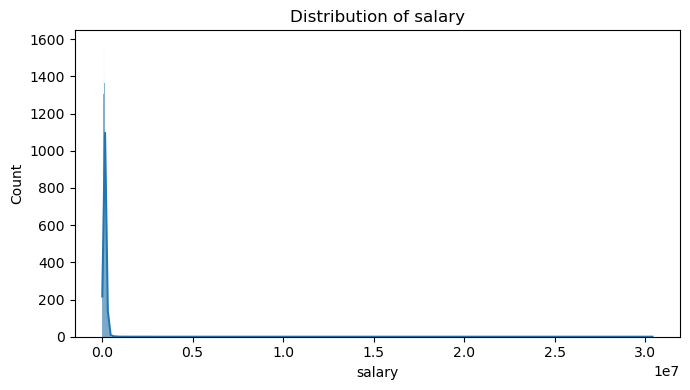

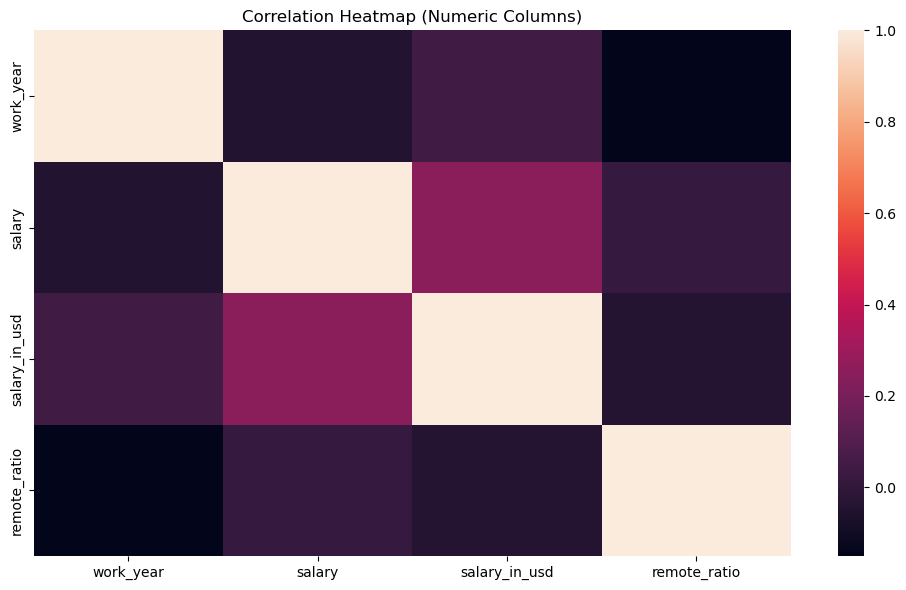

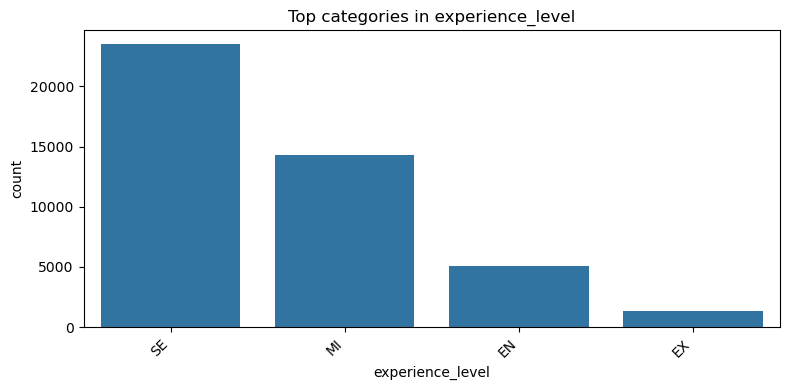

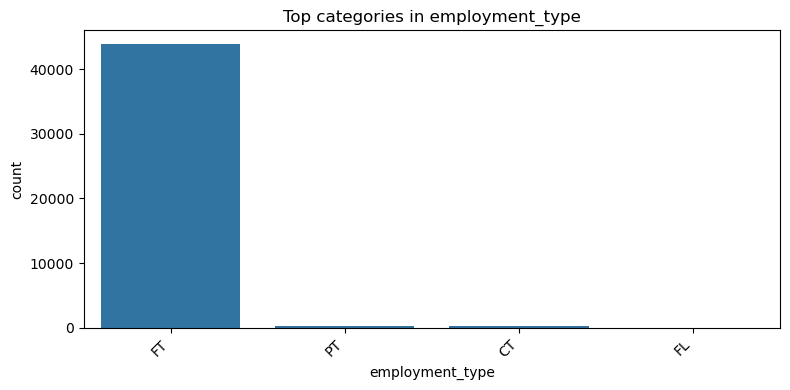

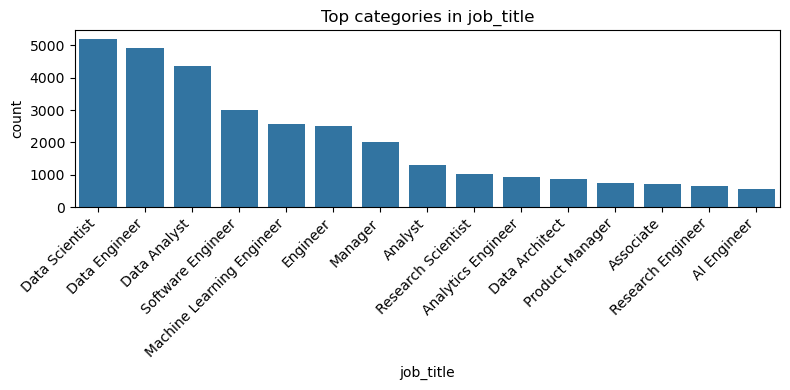

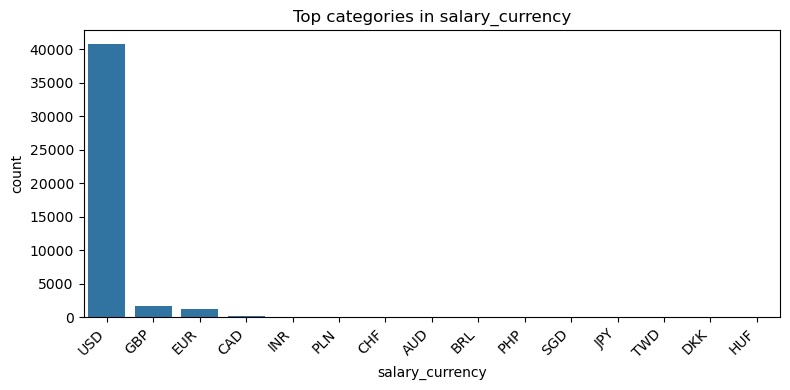

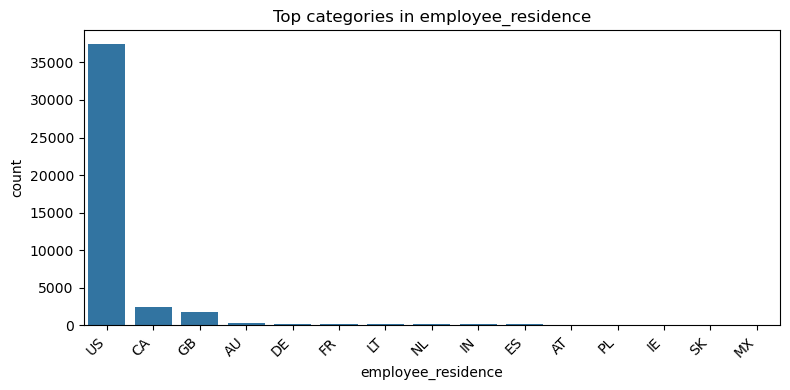

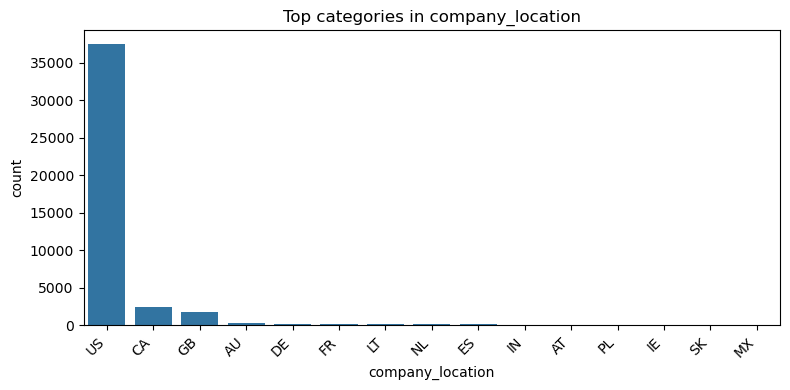

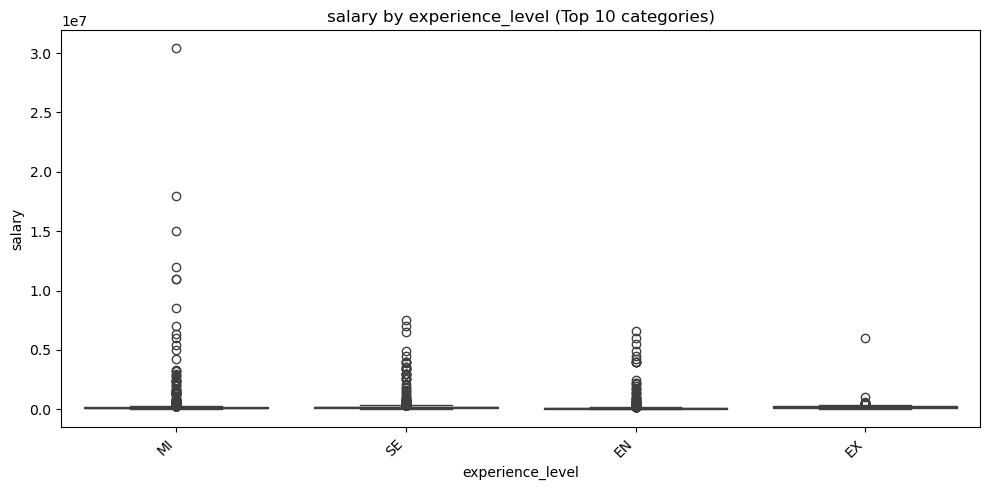


--- EDA Interpretation (paste into your notebook/report) ---

The histogram shows the overall distribution of salary, including skew and outliers.
The count plots show how the most common categories are distributed.
The boxplot compares salary across major categories, showing whether some groups
have noticeably higher or lower pay levels.



In [ ]:


# 4) Introduction
print("\n--- Introduction (paste into your notebook/report) ---")
print(f"""
This project uses salaries.csv, which contains salary/pay information along with
employee or job-related attributes (such as title, department, employment type, etc.).
The dataset contains {df.shape[0]} rows and {df.shape[1]} columns after cleaning.

Questions:
1) Which variables appear to be strongest drivers of salary/pay?
2) Can a decision tree model predict salary/pay with reasonable accuracy?
""")

# 5) EDA
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include="object").columns.tolist()

numeric_feature_cols = [c for c in numeric_cols if c != target_col]

print("\nNumeric columns:", numeric_cols[:20], "..." if len(numeric_cols) > 20 else "")
print("Categorical columns:", categorical_cols[:20], "..." if len(categorical_cols) > 20 else "")

#  5A) Histogram of target
plt.figure(figsize=(7,4))
sns.histplot(df[target_col], kde=True)
plt.title(f"Distribution of {target_col}")
plt.tight_layout()
plt.show()

#  5B) Correlation heatmap for numeric features
if len(numeric_cols) >= 2:
    plt.figure(figsize=(10,6))
    corr = df[numeric_cols].corr(numeric_only=True)
    sns.heatmap(corr, annot=False)
    plt.title("Correlation Heatmap (Numeric Columns)")
    plt.tight_layout()
    plt.show()

#  5C) Categorical countplots
cat_to_plot = categorical_cols[:6]
for col in cat_to_plot:
    plt.figure(figsize=(8,4))
    order = df[col].value_counts().head(15).index  # cap for readability
    sns.countplot(data=df, x=col, order=order)
    plt.title(f"Top categories in {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

#  5D) Boxplot: Salary by first categorical col
if len(categorical_cols) > 0:
    box_col = categorical_cols[0]
    top_cats = df[box_col].value_counts().head(10).index
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df[df[box_col].isin(top_cats)], x=box_col, y=target_col)
    plt.title(f"{target_col} by {box_col} (Top 10 categories)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

print("\n--- EDA Interpretation (paste into your notebook/report) ---")
print(f"""
The histogram shows the overall distribution of {target_col}, including skew and outliers.
The count plots show how the most common categories are distributed.
The boxplot compares {target_col} across major categories, showing whether some groups
have noticeably higher or lower pay levels.
""")

In [ ]:

# 6) Modeling Dataset
X = df.drop(columns=[target_col])
y = df[target_col]

X_encoded = pd.get_dummies(X, drop_first=True)

print("X_encoded shape:", X_encoded.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.30, random_state=42
)


X_encoded shape: (44244, 531)


In [ ]:

# 7) Decision Tree Regression
model = DecisionTreeRegressor(
    criterion="squared_error",
    max_depth=6,
    min_samples_leaf=10,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [ ]:

# 8) Evaluation

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Model Evaluation ---")
print("R² score:", round(r2, 4))
print("MAE:", round(mae, 2))

print("\n--- Metric Interpretation ---")
print(
    f"R² shows how much of the variation in {target_col} the model explains. "
    f"MAE is the average absolute prediction error in the same units as {target_col}. "
    f"Here, R² = {r2:.4f} and MAE = {mae:.2f}."
)


--- Model Evaluation ---
R² score: 0.5431
MAE: 18090.08

--- Metric Interpretation ---
R² shows how much of the variation in salary the model explains. MAE is the average absolute prediction error in the same units as salary. Here, R² = 0.5431 and MAE = 18090.08.


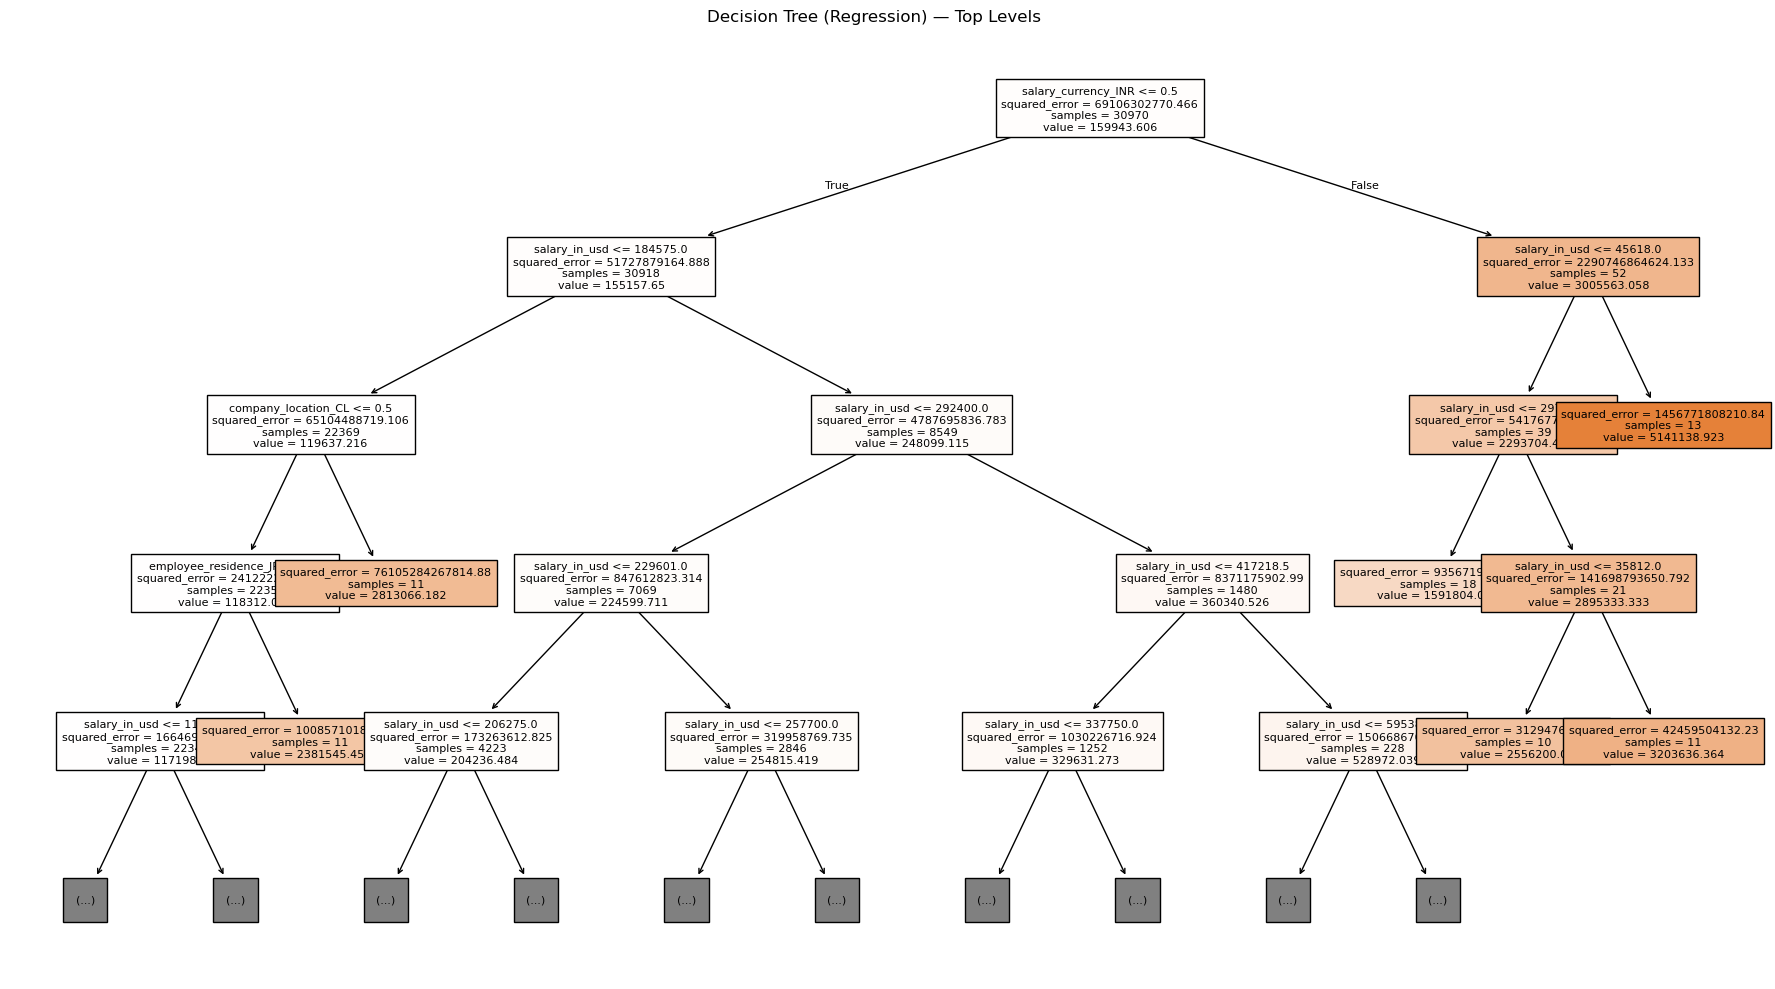

In [ ]:

# 9) Plot the Tree
plt.figure(figsize=(18,10))
tree.plot_tree(
    model,
    feature_names=X_encoded.columns,
    filled=True,
    max_depth=4,
    fontsize=8
)
plt.title("Decision Tree (Regression) — Top Levels")
plt.tight_layout()
plt.show()


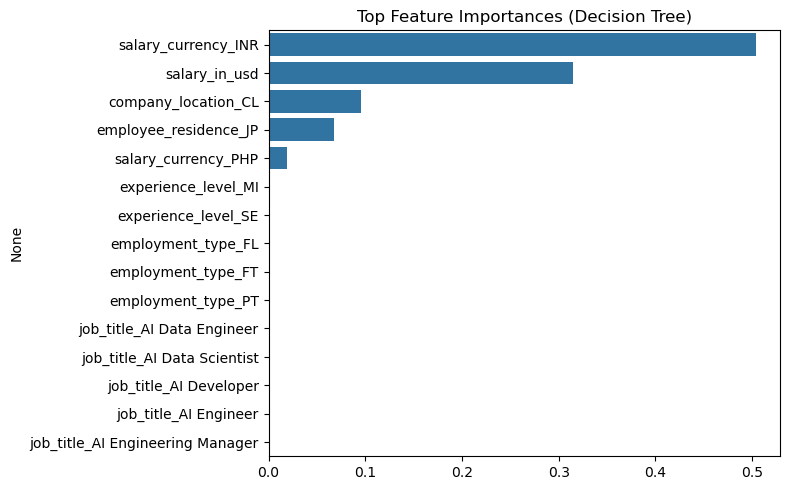


--- Model Interpretation (paste into your notebook/report) ---

The decision tree suggests that a small set of variables drives most of the splits,
which can be seen in the feature-importance chart. Features near the top of the tree
represent the strongest drivers of salary in this model.

Because decision trees can overfit, we limited depth and required a minimum leaf size.
Even so, performance should be judged by the test-set metrics (R² and MAE).



In [ ]:

# 10) Interpretation

importances = pd.Series(model.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)
top_imp = importances.head(15)

plt.figure(figsize=(8,5))
sns.barplot(x=top_imp.values, y=top_imp.index)
plt.title("Top Feature Importances (Decision Tree)")
plt.tight_layout()
plt.show()

print("\n--- Model Interpretation (paste into your notebook/report) ---")
print(f"""
The decision tree suggests that a small set of variables drives most of the splits,
which can be seen in the feature-importance chart. Features near the top of the tree
represent the strongest drivers of {target_col} in this model.

Because decision trees can overfit, we limited depth and required a minimum leaf size.
Even so, performance should be judged by the test-set metrics (R² and MAE).
""")
